# Perform inference with the component

After performing the evaluation in the previous notebook, we concluded that using LaREM with 256 PCA components seemed like a good configuration. Now we will see how to: 
 * Build a threshold for InD/OoD classification using a 95% confidence
 * Perform inference on new unseen images
 * Obtain the confidence score.

In [1]:
import torch
from torchvision import transforms
import numpy as np
from os.path import join as op_join
from icecream import ic
from PIL import Image
from deeplab_v3p import DeepLabV3PlusModule
from ls_ood_detect_cea.uncertainty_estimation import Hook, deeplabv3p_apply_dropout, LaRExInference, \
    MCSamplerModule, LaREMPostprocessor
from ls_ood_detect_cea import apply_pca_ds_split

In [2]:
# Inference parameters
entropy_samples_folder = "./entropy/"
ind_dataset_name = "woodscapes"
# hook_layer_type = "Dropblock"
layer_type = "Conv"
ws_dlv3p_path = "./checkpoints/last.ckpt"
MC_SAMPLES = 16
N_PCA_COMPONENTS = 256
ind_sample_image_path = "./test_images/00164_RV.png"
ood_sample_image_path = "./test_images/0094_RV.png"
z_95 = 1.645  # z score for 95% confidence
IMG_SIZE = (483, 640)  # Train image size

# Train the component modules with the selected parameters

## Load InD training and test entropies

We train the component using the same train, validation and test entropy samples used during the evaluation (no need to extract more features, they were already extracted in notebook 1)

In [3]:
# Load InD train entropies
ind_data_dict = {
    "h_z_train": np.load(file=op_join(entropy_samples_folder, f"{ind_dataset_name}_h_z_train.npy")),
    "h_z": np.concatenate(
        (
            np.load(file=op_join(entropy_samples_folder, f"{ind_dataset_name}_h_z_test.npy")),
            np.load(file=op_join(entropy_samples_folder, f"{ind_dataset_name}_h_z_valid.npy"))
        )
    )
}

## Train PCA module with the specified number of components, and LaREM postprocessor 

In [4]:
# Train PCA module and transform InD train samples
pca_ind_train, pca_transformation = apply_pca_ds_split(
    samples=ind_data_dict["h_z_train"],
    nro_components=N_PCA_COMPONENTS
)

# Setup LaREM postprocessor with the PCA transformed features
larem_ds_shift_detector = LaREMPostprocessor()
larem_ds_shift_detector.setup(pca_ind_train)

## Calculate threshold using an InD test set

In [6]:
# Calculate scores for the InD test set
test_ind_larem = larem_ds_shift_detector.postprocess(pca_transformation.transform(ind_data_dict["h_z"]))
# Calculate threshold
mean_ind_larem, std_ind_larem = np.mean(test_ind_larem), np.std(test_ind_larem)
# Here we use the 95% confidence z score
threshold_larem = mean_ind_larem - (z_95 * std_ind_larem) 
print(f"Threshold: {threshold_larem}")

Threshold: -315.06579081594293


# Load Deeplabv3+ Woodscape Trained Model to perform inference

In [7]:
# Load model
ws_dlv3p_model = DeepLabV3PlusModule.load_from_checkpoint(checkpoint_path=ws_dlv3p_path)
# Send to device and activate dropblock
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ws_dlv3p_model.deeplab_v3plus_model.to(device)
ws_dlv3p_model.deeplab_v3plus_model.eval()
ws_dlv3p_model.deeplab_v3plus_model.apply(deeplabv3p_apply_dropout)  # enable Dropblock

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [8]:
# Check that dropout/dropblock is active during inference
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1);
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob);
ic(ws_dlv3p_model.deeplab_v3plus_model.drop_block1.training);

ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1: DropBlock2D()
ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.drop_prob: 0.2
ic| ws_dlv3p_model.deeplab_v3plus_model.drop_block1.training: True


## Add Hook Deeplabv3+ Woodscape

In [9]:
ws_dlv3p_hook_dropblock2d_layer = Hook(ws_dlv3p_model.deeplab_v3plus_model.drop_block1)

# Instantiate inference module

In [10]:
# Instantiate sampler
larem_inference_module = LaRExInference(
    dnn_model=ws_dlv3p_model.deeplab_v3plus_model,
    detector=larem_ds_shift_detector,
    mcd_sampler=MCSamplerModule,
    pca_transform=pca_transformation,
    mcd_samples_nro=MC_SAMPLES,
    layer_type=layer_type
)

# Load images

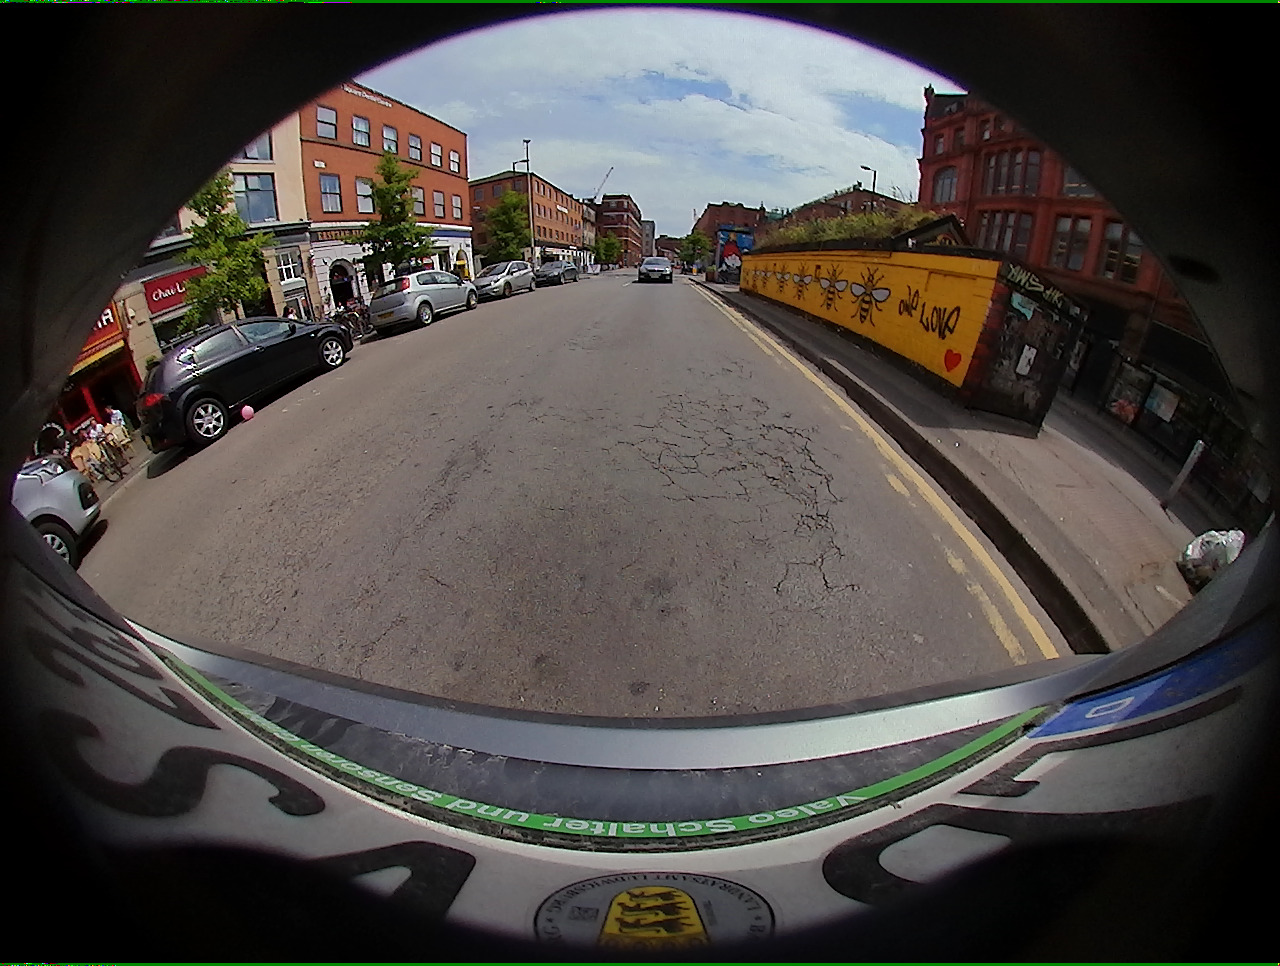

In [11]:
# Load test images
ind_img = Image.open(ind_sample_image_path)
ood_img = Image.open(ood_sample_image_path)

# Apply same transformations as training
woodscape_img_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.32757252, 0.33050337, 0.33689716],
            std=[0.20290555, 0.20525302, 0.2037721],
        ),
    ]
)
ind_tensor_img = woodscape_img_transforms(ind_img).unsqueeze(0)
ood_tensor_img = woodscape_img_transforms(ood_img).unsqueeze(0)
# Visualize Ind image
ind_img

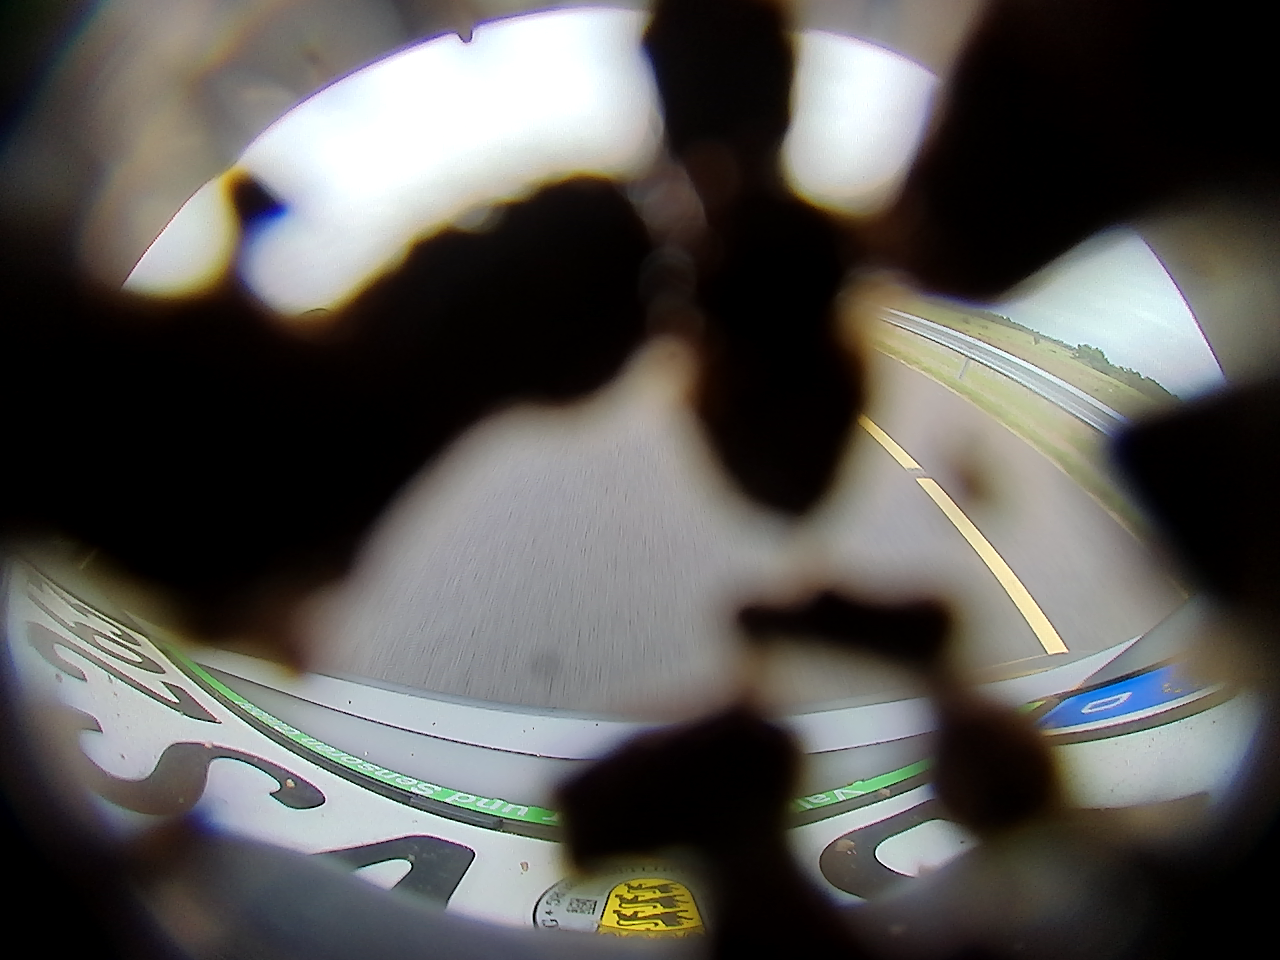

In [12]:
# Visualize ood image
ood_img

In [13]:
# Perform inference and get scores
# torch.manual_seed(0)  # For reproducibility
ind_prediction, ind_img_score = larem_inference_module.get_score(ind_tensor_img, layer_hook=ws_dlv3p_hook_dropblock2d_layer)
ood_prediction, ood_img_score = larem_inference_module.get_score(ood_tensor_img, layer_hook=ws_dlv3p_hook_dropblock2d_layer)

In [14]:
print(f"InD test image score: {ind_img_score}, Ind score above threshold: {ind_img_score > threshold_larem}")
print(f"OoD test image score: {ood_img_score}, Ind score above threshold: {ood_img_score > threshold_larem}")

InD test image score: [-237.8459793], Ind score above threshold: [ True]
OoD test image score: [-1041.78596342], Ind score above threshold: [False]
